In [3]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2
import skimage
import skimage.io as skio
import scipy.misc

import random

import torch
import torch.nn as nn
from torch.utils import data
from torchvision.models import vgg19, resnet50
from torchvision import transforms
from torch.utils.data import DataLoader
from PIL import Image
from torchvision import datasets
from torch.utils.data.dataset import Dataset

import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
from sklearn import preprocessing
from skimage.transform import resize
from sklearn.metrics import accuracy_score

from pycocotools.coco import COCO

from tqdm import tqdm

import pandas as pd
import pickle

# Custom functions
from model import VGG
from dataloader import DatasetProcessing
from eval_metrics import calc_iou
from clustering import get_clustering_functions
from postprocessing import get_generate_bbox, get_superimposed_img

In [4]:
DATA_PATH = "/media/HD1/sriram/data/coco"
TEST_IMG_PATH = "val2017"
TEST_ANN_PATH = "instances_val2017.json"
MODEL_PATH = "/media/HD1/sriram/models/vgg_train_coco_80classes.pt"

In [5]:
from torchvision import transforms
from torch.utils.data import DataLoader
from PIL import Image


transformations = transforms.Compose([
    transforms.Scale(224),
    transforms.CenterCrop(224),
    transforms.ToTensor()])

Create a dataset class to pre-process the images and return the images, ground truth labels and ground truth bounding boxes

In [6]:
class DatasetRetrieve(Dataset):
    def __init__(self, data_path, img_path, ann_path, transform=None):
        
        self.ann_path = os.path.join(data_path, "annotations", ann_path)
        self.img_path = os.path.join(data_path, img_path)       

        coco=COCO(self.ann_path)
        catIDs = coco.getCatIds()

        annIDs = coco.getAnnIds(catIds=catIDs, iscrowd = None)
        anns = coco.loadAnns(ids=annIDs)        

        imgIDs = []
        labelIDs = []
        bboxDims = []
        for i in range(0,len(anns)):
            imgIDs.append(anns[i]['image_id'])
            labelIDs.append(anns[i]['category_id'])
            bboxDims.append(anns[i]['bbox'])

        imgIDs = np.array(imgIDs)
        labelIDs = np.array(labelIDs)
        bboxDims = np.array(bboxDims)
        uniqueImgIDs = np.unique(imgIDs)

        uniqueTargetLabels = []
        uniqueTargetbboxes = []
        bboxLabels = []
        orderedLabels = np.arange(0,len(catIDs))
        for i in tqdm(range(0,len(uniqueImgIDs))):
            targetLabels = labelIDs[imgIDs == uniqueImgIDs[i]]
            targetbboxes = bboxDims[imgIDs == uniqueImgIDs[i]]
            uniqueLabels = np.unique(targetLabels)
            actualLabels = np.zeros(len(uniqueLabels))
            actualbboxLabels = np.zeros(len(targetLabels))
            for j in range(0,len(uniqueLabels)):
                actualLabels[j] = orderedLabels[catIDs == uniqueLabels[j]]
            for j in range(0,len(targetLabels)):
                actualbboxLabels[j] = orderedLabels[catIDs == targetLabels[j]]
            uniqueTargetLabels.append(actualLabels)
            uniqueTargetbboxes.append(targetbboxes)
            bboxLabels.append(actualbboxLabels)

        uniqueImgIDs = uniqueImgIDs.tolist()
        imgs = coco.loadImgs(ids=uniqueImgIDs)

        imgFilenames = []
        labels = np.zeros((len(imgs),len(catIDs)))
        for i in range(0,len(imgs)):
            imgFilenames.append(imgs[i]['file_name'])    
            uniqueTargetLabels[i] = uniqueTargetLabels[i].astype(np.uint8)        
            labels[i,uniqueTargetLabels[i]] = 1

        self.img_filename = imgFilenames
        self.label = labels
        self.bboxes = uniqueTargetbboxes
        self.bboxLabels = bboxLabels
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_path, self.img_filename[index]))
        img = img.convert('RGB')
        img = np.array(img)

        def resize_with_padding(im, desired_size = 224):
            """ Resize Image into a square based on desired_size with padding
            """
            old_size = im.shape[:2] # old_size is in (height, width) format

            ratio = float(desired_size)/max(old_size)
            new_size = tuple([int(x*ratio) for x in old_size])

            # new_size should be in (width, height) format

            im = cv2.resize(im, (new_size[1], new_size[0]))

            delta_w = desired_size - new_size[1]
            delta_h = desired_size - new_size[0]
            top, bottom = delta_h//2, delta_h-(delta_h//2)
            left, right = delta_w//2, delta_w-(delta_w//2)

            color = [0, 0, 0]
            new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,
                value=color)
            return new_im

        def rescale_box(bboxes, im_path, desired_size=224):
            im = cv2.imread(im_path)
            old_size = im.shape[:2]
            ratio = float(desired_size)/max(old_size)
            new_size_image = tuple([int(x*ratio) for x in old_size])
            new_size_box = tuple([int(x*ratio) for x in bboxes])
            x,y,w,h = new_size_box
            delta_w = desired_size - new_size_image[1]
            delta_h = desired_size - new_size_image[0]
            if delta_w > 0:
                x = x + delta_w//2
            if delta_h > 0:
                y = y + delta_h//2
            return x,y,w,h

        img = resize_with_padding(img)
        img = Image.fromarray(img)

        if self.transform is not None:
            img = self.transform(img)

        label = torch.from_numpy(self.label[index]).clone()

        bboxesNew = []
        for i in range(0,len(self.bboxes[index])):
            xNew,yNew,wNew,hNew = rescale_box(self.bboxes[index][i],os.path.join(self.img_path, self.img_filename[index]))
            bboxesNew.append([xNew,yNew,wNew,hNew])
        
        bboxLabel = self.bboxLabels[index]

        return img, label, bboxesNew, bboxLabel
    
    def __len__(self):
        return len(self.img_filename)

In [7]:
test_data = DatasetRetrieve(DATA_PATH, TEST_IMG_PATH, TEST_ANN_PATH, transform=transformations)

loading annotations into memory...
Done (t=0.31s)
creating index...
index created!


100%|██████████| 4952/4952 [00:00<00:00, 9913.60it/s]


Function definitions for the object localization algorithms to be tried 

In [8]:
def draw_bounding_box(box,img,color = 'red'):
    
    if color == 'blue':
        colorTuple = (255,0,0)
    elif color == 'green':
        colorTuple = (0,255,0)
    elif color == 'red':
        colorTuple = (0,0,255) 
    elif color == 'purple':
        colorTuple = (128,0,128)
    elif color == 'yellow':
        colorTuple = (0,255,255)
    elif color == 'orange':
        colorTuple = (0,121,255)

    x,y,w,h = box
    img = cv2.rectangle(img, (x,y), (x+w, y+h), colorTuple, 2)

    return img

In [9]:
def merge_heatmaps(heatmapOriginal, heatmapClusters,numClusters = 3):
    
    MAX_THRESHOLD = 0.8
    OVERLAP_THRESHOLD = 0.8

    # Overlap the heatmaps by only taking intersections with GradCAM++
    heatmapGradCAMPlus = cv2.cvtColor(heatmapOriginal.copy(),cv2.COLOR_BGR2RGB)
    # Blurring for removing the noise 
    heatmapGradCAMPlus = cv2.bilateralFilter(heatmapGradCAMPlus, d = 5, sigmaSpace = 75, sigmaColor =75)       
    # Convert to grayscale 
    heatmapGradCAMPlus = cv2.cvtColor(heatmapGradCAMPlus, cv2.COLOR_RGB2GRAY)
    # thresholding as per CAM paper, setting too low a threshold is unable to get the box
    maxVal = heatmapGradCAMPlus.max()  
    _, threshGradCAMPlus = cv2.threshold(heatmapGradCAMPlus, maxVal*MAX_THRESHOLD, maxVal,cv2.THRESH_BINARY)

    # Find the largest contour in Grad-CAM++ threshold heatmap
    contours,hierarchy = cv2.findContours(threshGradCAMPlus, mode = cv2.RETR_TREE, method = cv2.CHAIN_APPROX_NONE) # previous was 1, 2
    contours = sorted(contours, key = cv2.contourArea, reverse = True)
    largestContour = np.squeeze(contours[0])

    for i in range(0,numClusters):

        heatmapCluster = cv2.cvtColor(heatmapClusters[i,:].copy(),cv2.COLOR_BGR2RGB)        
        heatmapCluster = cv2.bilateralFilter(heatmapCluster, d = 5, sigmaSpace = 75, sigmaColor =75)
        heatmapCluster = cv2.cvtColor(heatmapCluster,cv2.COLOR_RGB2GRAY)
        maxVal = heatmapCluster.max()
        _, threshGradCAMCluster = cv2.threshold(heatmapCluster, maxVal*OVERLAP_THRESHOLD, maxVal,cv2.THRESH_BINARY)
        contours,hierarchy = cv2.findContours(threshGradCAMCluster, mode = cv2.RETR_TREE, method = cv2.CHAIN_APPROX_NONE) # previous was 1, 2
        contours = sorted(contours, key = cv2.contourArea, reverse = True)

        for j in range(0,len(contours)):
            contour = np.squeeze(contours[j])

            if contour.ndim < 2:
                contour = np.expand_dims(contour,0)

            intersect = False
            for k in range(0,contour.shape[0]):
                if contour[k,:].tolist() in largestContour.tolist():
                    intersect = True
                    break

            if intersect == True:
                largestContour = np.concatenate((largestContour,contour),axis=0)

    contourJoined = np.zeros([heatmapCluster.shape[0],heatmapCluster.shape[1]])
    for k in range(0,largestContour.shape[0]):
        contourJoined[largestContour[k,1],largestContour[k,0]] = 1

    # plt.figure()
    # plt.imshow(contourJoined)

    contoursRedraw = cv2.findContours(contourJoined.astype(np.uint8),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
    contourSizeBuff = np.zeros([len(contoursRedraw[0])])
    for i in range(0,len(contoursRedraw[0])):
        contourSizeBuff[i] = contoursRedraw[0][i].shape[0]
    largestContourIdx = np.argmax(contourSizeBuff)

    box = []
    x,y,w,h = cv2.boundingRect(contoursRedraw[0][largestContourIdx])
    box.append([x,y,w,h])

    return box

In [18]:
def get_pos_lbl(img, heatmap_in, lblIdx, model, train_on_gpu):
    """ Returns the pos label (pixel value with the least pixel count)
    """
    img01 = img.detach().clone()
    img02 = img.detach().clone()
    
    heatmap01 = heatmap_in.copy()
    heatmap02 = heatmap_in.copy()
    heatmap01[heatmap01<128] = 0
    heatmap01[heatmap01>=128] = 1
    heatmap01 = np.abs(1 - heatmap01 )

    heatmap02[heatmap02<128] = 0
    heatmap02[heatmap02>=128] = 1
    heatmap02 = np.abs(heatmap02)
    
    if train_on_gpu:
        img_x = img01.cpu().detach() * heatmap01
        pred = model(img_x.cuda(device='cuda:1'))
    else:
        img_x = img01 * heatmap01
        pred = model(img_x)
    pred01 = torch.sigmoid(pred)

    # Image for display (to save for visualization)
    img_d = np.transpose(img_x.numpy()[0], (1,2,0))

    # Original heatmap
    if train_on_gpu:
        img_y = img02.cpu().detach() * heatmap02
        pred = model(img_y.cuda(device='cuda:1'))
    else:
        img_y = img02 * heatmap02
        pred = model(img_y)
    pred02 = torch.sigmoid(pred)
    
    # Image for display (to save for visualization)
    img_d = np.transpose(img_y.numpy()[0], (1,2,0)) 
    
    if pred01[0][lblIdx] > pred02[0][lblIdx]:
        # Invert Heatmap
        invert = True
    else:
        # Retain current values
        invert = False
    return invert

Load some saved image indices for which there were correct classifications to visualize some sample results

In [11]:
loadFile = "/media/HD1/sriram/results/IOU_80classes.pkl"
openFile = open(loadFile,'rb')
iouBuffGradCAM = pickle.load(openFile)
iouBuffGradCAMPlus = pickle.load(openFile)
iouBuffCluster = pickle.load(openFile)
iouBuffGradCAMBinaryClust = pickle.load(openFile)
iouBuffGradCAMPlusBinaryClust = pickle.load(openFile)
gtClassBuff = pickle.load(openFile)
predictedScoresBuff = pickle.load(openFile)
idxBuff = pickle.load(openFile)
openFile.close()

print(idxBuff)

[1, 22, 48, 52, 66, 78, 107, 147, 150, 183, 198, 213, 224, 228, 232, 235, 265, 271, 280, 297, 314, 323, 347, 359, 369, 386, 393, 399, 409, 410, 414, 428, 464, 468, 470, 482, 485, 495, 507, 510, 512, 520, 523, 542, 547, 572, 574, 581, 590, 613, 640, 667, 669, 702, 719, 727, 742, 745, 758, 764, 769, 772, 779, 786, 797, 798, 801, 806, 810, 816, 832, 848, 850, 864, 870, 872, 878, 881, 882, 884, 894, 896, 917, 926, 932, 947, 953, 959, 974, 988, 1003, 1020, 1039, 1055, 1061, 1084, 1087, 1092, 1095, 1104, 1108, 1114, 1118, 1134, 1161, 1175, 1181, 1187, 1189, 1195, 1216, 1217, 1219, 1223, 1265, 1274, 1279, 1292, 1308, 1309, 1311, 1313, 1314, 1317, 1327, 1345, 1357, 1363, 1376, 1386, 1398, 1403, 1405, 1407, 1416, 1424, 1433, 1434, 1436, 1439, 1442, 1484, 1488, 1496, 1504, 1508, 1512, 1515, 1522, 1533, 1538, 1544, 1545, 1550, 1556, 1574, 1596, 1611, 1617, 1618, 1619, 1620, 1632, 1667, 1669, 1673, 1687, 1709, 1712, 1713, 1719, 1735, 1736, 1752, 1757, 1760, 1768, 1777, 1799, 1817, 1828, 1829, 1831

Evaluate object localization performance using 
1) Grad-CAM
2) Grad-CAM++
3) A gradient clustering technique using Grad-CAM++ 
4) Binary clustering on feature maps using Grad-CAM 
5) Binary clustering on feature maps using Grad-CAM++

IOU GradCAM: 0.366
IOU GradCAMPlus: 0.267
IOU Cluster: 0.187
IOU GradCAM Binary Clustering: 0.321
IOU GradCAMPlus Binary Clustering: 0.321
Predicted Class Label: 11
Ground Truth Class Label: 11
Image Index: 150


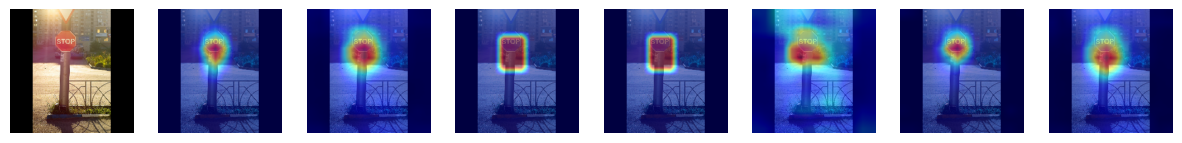

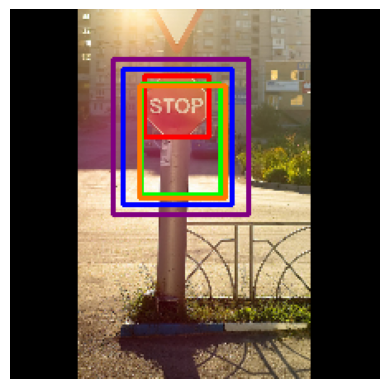

In [62]:
# Setting of parameter constants
LAYER_IDX = 36
CLASSIFICATION_THRESHOLD = 0.5
NUM_CLUSTERS_GRADIENTS = 3
NUM_CLASSES = 80

# Setting algo option flags
ENABLE_CLUSTER_ALGO = True
PLOT_RESULTS = False        # Set to True to visualize results for each image

# Initialize variables
numClusters = NUM_CLUSTERS_GRADIENTS
getClusterMaps = ENABLE_CLUSTER_ALGO
totalObjects = 0
objectClassCount = np.zeros(NUM_CLASSES)

# Initialize buffers
iouBuffGradCAM                  = []
iouBuffGradCAMPlus              = []
iouBuffCluster                  = []
iouBuffGradCAMBinaryClust       = []
iouBuffGradCAMPlusBinaryClust   = []
gtClassBuff                     = []
predictedClassBuff              = []
predictedScoresBuff             = []
imgIdxBuff                      = []

### Run this loop to visualize some sample results
# randIdx = np.random.randint(0,len(idxBuff)-1)
# ii = idxBuff[randIdx]
# for ii in range(ii,ii+1):

# Run this loop to run object localization over all images
for ii in tqdm(range(0,len(test_data))):

    img_in,lbls,bboxes,boxLabels = test_data[ii]
      
    img = torch.clone(img_in)
    img = img.unsqueeze(0)

    # We filter images which contain only one target object.
    bboxesSingle = []
    finalLabels = []
    for j in range(0,len(boxLabels)):
        count = boxLabels.tolist().count(boxLabels[j])
        if count == 1:
            bboxesSingle.append(bboxes[j])
            finalLabels.append(int(boxLabels[j]))

    positiveLabelIndices = finalLabels

    # Only consider images that contain a single target object
    if len(positiveLabelIndices) != 1:
        continue

    gtClassBuff.append(positiveLabelIndices[0])
    totalObjects += len(positiveLabelIndices)
    objectClassCount[positiveLabelIndices] += 1 

    train_on_gpu = torch.cuda.is_available()

    # initialize the VGG model
    vgg = VGG(LAYER_IDX, model_path=MODEL_PATH)
    if train_on_gpu:
        vgg.cuda(device='cuda:1')
        img = img.cuda(device='cuda:1')

    # set the evaluation mode
    vgg.eval()

    output = vgg(img)

    # Consider only 1 target object per image
    output_copy = torch.clone(output)
    output_copy = torch.sigmoid(output_copy.detach().cpu()).squeeze(0)
    pred_index = np.argmax(output_copy.numpy())
    predictedClassBuff.append(pred_index)
    predictedScoresBuff.append(output_copy.numpy())

    # Compute true positives(hits) and false negatives(misses)
    # Do Grad-CAM for true positives
    reluOp = torch.nn.ReLU()
    for idx in range(0,len(positiveLabelIndices)):

        labelIndex = positiveLabelIndices[idx]
        gtBBox = bboxesSingle[idx]
        if gtBBox[2] == 0:
            gtBBox[2] = 1
        if gtBBox[3] == 0:
            gtBBox[3] = 1

        imgIdxBuff.append(ii)

        # Take exponential of the scores
        predExp = torch.exp(output[:,labelIndex]).cpu()       

        # get the gradients of the feature maps with respect to the predicted class
        output[:, labelIndex].backward()

        # pull the gradients out of the model
        gradients = vgg.get_activations_gradient().detach().cpu()
        gradients = gradients.squeeze(0)

        # get the activations of the last convolutional layer
        activations = vgg.get_activations(img).detach()
        if train_on_gpu:
            act_tnsr = activations[0].detach().cpu()
        else:
            act_tnsr = activations[0].numpy()

        # Compute feature map for original Grad-CAM
        gradMean = torch.mean(gradients,(1,2))
        weightActv = torch.zeros([gradients.shape[0],gradients.shape[1],gradients.shape[2]])
        for n in range(0,gradients.shape[0]):
            weightActv[n,:] = torch.mul(act_tnsr[n,:],gradMean[n])
        heatmapGradCAM = reluOp(torch.sum(weightActv,0))

        # Use binary clustering to aggregate GradCAM heatmap
        aggActvGradCAM = torch.clone(weightActv)
        aggActvGradCAM = aggActvGradCAM.view(aggActvGradCAM.shape[0],aggActvGradCAM.shape[1]*aggActvGradCAM.shape[2]).detach().numpy()
        aggActvGradCAM = np.transpose(aggActvGradCAM)
        heatmapGradCAMBinaryClust = get_clustering_functions(aggActvGradCAM, 'kmeans', n_clusters = 2)
        heatmapGradCAMBinaryClust = np.reshape(heatmapGradCAMBinaryClust, (14, 14))

        # Computation of Grad-CAM++ maps

        # Compute weighting coefficients for the gradients
        gradWeights1 = torch.pow(gradients,2)
        gradWeights2 = torch.pow(gradients,3)
        gradWeightsDen1 = torch.sum(act_tnsr,(1,2))
        gradWeightsDen2 = torch.zeros([gradWeights2.shape[0],gradWeights2.shape[1],gradWeights2.shape[2]])
        for n in range(0,gradWeights2.shape[0]):
            gradWeightsDen2[n,:] = torch.mul(gradWeights2[n,:],gradWeightsDen1[n])
        gradWeightsDen3 = torch.mul(gradWeights1,2)
        gradWeightsDen = torch.add(gradWeightsDen2,gradWeightsDen3)
        gradWeightsDen = torch.where(gradWeightsDen != 0,gradWeightsDen,torch.tensor([1.0]))
        gradWeightCoeffs = torch.div(gradWeights1,gradWeightsDen)
        gradients = torch.mul(gradients,predExp)
        gradReLU = reluOp(gradients)

        # Normalize the weighting coefficients by their sum over the feature map
        coeffSum = torch.sum(gradWeightCoeffs,(1,2))
        for n in range(0,gradWeightCoeffs.shape[0]):
            gradWeightCoeffs[n,:] = torch.div(gradWeightCoeffs[n,:],coeffSum[n])

            alphaNorm = torch.where(gradReLU[n,:] > 0,gradWeightCoeffs[n,:],torch.tensor([0.0]))
            coeffSum2 = torch.sum(alphaNorm)
            if coeffSum2 == 0.0:
                coeffSum2 = 1.0
            gradWeightCoeffs[n,:] = torch.div(gradWeightCoeffs[n,:],coeffSum2)

        # Multiply positive gradients with weighting coefficients and sum
        gradCamWeights1 = torch.mul(gradWeightCoeffs,gradReLU)
        gradCamWeights = torch.sum(gradCamWeights1,(1,2))

        if train_on_gpu:
            img_rgb = np.transpose(img.cpu().detach()[0], (1,2,0)).numpy()
        else:
            img_rgb = np.transpose(img[0], (1,2,0)).numpy()

        # Get the individual heatmaps for clustering method
        heatmapOnImageClusters = np.zeros([numClusters,img.shape[2],img.shape[3],3]).astype(np.uint8)
        heatmapClusters = np.zeros([numClusters,img.shape[2],img.shape[3],3]).astype(np.uint8)

        if getClusterMaps == True:

            # Try to cluster the gradient weights after they have been summed across each feature map
            gradCamWgts = gradCamWeights.view(gradCamWeights.shape[0],1).detach().numpy()
            gradClusterIDs = get_clustering_functions(gradCamWgts,'kmeans',n_clusters=numClusters)
            heatmapClusters = np.zeros([numClusters,img.shape[2],img.shape[3],3]).astype(np.uint8)
            for n in range(0,numClusters):
                actvMapLayers = act_tnsr[gradClusterIDs == n,:]
                gradVals = gradCamWeights[gradClusterIDs == n]
                for k in range(0,len(gradVals)):
                    actvMapLayers[k,:] = torch.mul(actvMapLayers[k,:],gradVals[k])
                    heatmap = reluOp(torch.sum(actvMapLayers,0))
                if train_on_gpu:
                    heatmap = heatmap.cpu().detach().numpy()

                heatmapMax = np.amax(heatmap,(0,1))
                if heatmapMax == 0.0:
                    heatmapMax = 1.0
                heatmap = np.float32(heatmap)/heatmapMax
                heatmap = np.uint8(heatmap*255)   
                heatmap = cv2.resize(heatmap,(img_rgb.shape[1], img_rgb.shape[0]))
                heatmap_final = heatmap.astype(np.uint8)
                heatmap_final = cv2.applyColorMap(heatmap_final, cv2.COLORMAP_JET)
                superimposed_img = get_superimposed_img(img_rgb, heatmap_final)

                heatmapClusters[n,:] = heatmap_final.copy()
                heatmapOnImageClusters[n,:] = superimposed_img[...,::-1]

        # Original GradCAM++ Sum weighted activation maps and apply ReLU
        weightedActivations = torch.zeros([act_tnsr.shape[0],act_tnsr.shape[1],act_tnsr.shape[2]])
        for n in range(0,act_tnsr.shape[0]):
            weightedActivations[n,:] = torch.mul(act_tnsr[n,:],gradCamWeights[n])
        heatmapGradCAMPlus = reluOp(torch.sum(weightedActivations,0))
        
        if train_on_gpu:
            heatmapGradCAM = heatmapGradCAM.detach().cpu()
            heatmapGradCAMPlus = heatmapGradCAMPlus.cpu().detach()

        heatmapGradCAM = heatmapGradCAM.numpy()
        heatmapGradCAMPlus = heatmapGradCAMPlus.numpy()        

        # Use binary clustering to aggregate GradCAM++ heatmap
        aggActv = torch.clone(weightedActivations)
        aggActv = aggActv.view(aggActv.shape[0],aggActv.shape[1]*aggActv.shape[2]).detach().numpy()
        aggActv = np.transpose(aggActv)
        heatmapGradCAMPlusBinaryClust = get_clustering_functions(aggActv, 'kmeans', n_clusters = 2)
        heatmapGradCAMPlusBinaryClust = np.reshape(heatmapGradCAMPlusBinaryClust, (14, 14))

        # Heatmap for original GradCAM
        heatmapGradCAM = np.float32(heatmapGradCAM)/np.amax(heatmapGradCAM,(0,1))
        heatmapGradCAM = np.uint8(heatmapGradCAM*255)   
        heatmapGradCAM = cv2.resize(heatmapGradCAM,(img_rgb.shape[1], img_rgb.shape[0]))
        heatmap_finalGradCAM = heatmapGradCAM.astype(np.uint8)
        heatmap_finalGradCAM = cv2.applyColorMap(heatmap_finalGradCAM, cv2.COLORMAP_JET)

        # Heatmap for original GradCAM++
        heatmapGradCAMPlus = np.float32(heatmapGradCAMPlus)/np.amax(heatmapGradCAMPlus,(0,1))
        heatmapGradCAMPlus = np.uint8(heatmapGradCAMPlus*255)   
        heatmapGradCAMPlus = cv2.resize(heatmapGradCAMPlus,(img_rgb.shape[1], img_rgb.shape[0]))
        heatmap_finalGradCAMPlus = heatmapGradCAMPlus.astype(np.uint8)
        heatmap_finalGradCAMPlus = cv2.applyColorMap(heatmap_finalGradCAMPlus, cv2.COLORMAP_JET)
    
        superimposed_img_GradCAM = get_superimposed_img(img_rgb, heatmap_finalGradCAM) 
        superimposed_img_GradCAMPlus = get_superimposed_img(img_rgb, heatmap_finalGradCAMPlus)

        superimposed_img_GradCAM = superimposed_img_GradCAM[...,::-1]
        superimposed_img_GradCAMPlus = superimposed_img_GradCAMPlus[...,::-1]    

        # Heatmap for binary clustering with GradCAM++
        heatmapGradCAMPlusBinaryClust = np.float32(heatmapGradCAMPlusBinaryClust) / np.max(heatmapGradCAMPlusBinaryClust)
        heatmapGradCAMPlusBinaryClust = np.uint8(heatmapGradCAMPlusBinaryClust * 255)
        heatmapGradCAMPlusBinaryClust = cv2.resize(heatmapGradCAMPlusBinaryClust, (224, 224), cv2.INTER_AREA)
        pos_lbl = get_pos_lbl(img, heatmapGradCAMPlusBinaryClust, labelIndex, vgg, train_on_gpu)
        if pos_lbl:
            # Invert Heatmap
            # Seed is not in red box
            heatmapGradCAMPlusBinaryClust = 255 - heatmapGradCAMPlusBinaryClust
            heatmapGradCAMPlusBinaryClust = np.abs(heatmapGradCAMPlusBinaryClust)

        heatmap_finalGradCAMPlusBinaryClust = heatmapGradCAMPlusBinaryClust.astype(np.uint8)
        heatmap_finalGradCAMPlusBinaryClust = cv2.applyColorMap(heatmap_finalGradCAMPlusBinaryClust, cv2.COLORMAP_JET)

        superimposed_img_GradCAMPlusBinaryClust = get_superimposed_img(img_rgb, heatmap_finalGradCAMPlusBinaryClust)
        superimposed_img_GradCAMPlusBinaryClust = superimposed_img_GradCAMPlusBinaryClust[...,::-1]

        # Heatmap for binary clustering with GradCAM
        heatmapGradCAMBinaryClust = np.float32(heatmapGradCAMBinaryClust) / np.max(heatmapGradCAMBinaryClust)
        heatmapGradCAMBinaryClust = np.uint8(heatmapGradCAMBinaryClust * 255)
        heatmapGradCAMBinaryClust = cv2.resize(heatmapGradCAMBinaryClust, (224, 224), cv2.INTER_AREA)
        pos_lbl = get_pos_lbl(img, heatmapGradCAMBinaryClust, labelIndex, vgg, train_on_gpu)
        if pos_lbl:
            # Invert Heatmap
            # Seed is not in red box
            heatmapGradCAMBinaryClust = 255 - heatmapGradCAMBinaryClust
            heatmapGradCAMBinaryClust = np.abs(heatmapGradCAMBinaryClust)

        heatmap_finalGradCAMBinaryClust = heatmapGradCAMBinaryClust.astype(np.uint8)
        heatmap_finalGradCAMBinaryClust = cv2.applyColorMap(heatmap_finalGradCAMBinaryClust, cv2.COLORMAP_JET)

        superimposed_img_GradCAMBinaryClust = get_superimposed_img(img_rgb, heatmap_finalGradCAMBinaryClust)
        superimposed_img_GradCAMBinaryClust = superimposed_img_GradCAMBinaryClust[...,::-1]

        # Generate the bounding boxes from the heatmaps

        boxesGradCAM = get_generate_bbox(heatmap_finalGradCAM, thresh_max=0.8) 
        bboxGradCAM = boxesGradCAM[0]

        boxesGradCAMPlus = get_generate_bbox(heatmap_finalGradCAMPlus, thresh_max=0.8) 
        bboxGradCAMPlus = boxesGradCAMPlus[0]

        if ENABLE_CLUSTER_ALGO == True:
            boxesCluster = merge_heatmaps(heatmap_finalGradCAMPlus,heatmapClusters,numClusters = NUM_CLUSTERS_GRADIENTS)
            bboxCluster = boxesCluster[0]

        boxesGradCAMPlusBinaryClust = get_generate_bbox(heatmap_finalGradCAMPlusBinaryClust, thresh_max=0.8)
        bboxGradCAMPlusBinaryClust = boxesGradCAMPlusBinaryClust[0]

        boxesGradCAMBinaryClust = get_generate_bbox(heatmap_finalGradCAMBinaryClust, thresh_max=0.8)
        bboxGradCAMBinaryClust = boxesGradCAMBinaryClust[0]

        # Calculate iou for the bounding boxes

        iouGradCAM = calc_iou(gtBBox,bboxGradCAM)
        iouBuffGradCAM.append(iouGradCAM)

        iouGradCAMPlus = calc_iou(gtBBox,bboxGradCAMPlus)
        iouBuffGradCAMPlus.append(iouGradCAMPlus)

        iouCluster = calc_iou(gtBBox,bboxCluster)
        iouBuffCluster.append(iouCluster)

        iouGradCAMPlusBinaryClust = calc_iou(gtBBox, bboxGradCAMPlusBinaryClust)
        iouBuffGradCAMPlusBinaryClust.append(iouGradCAMPlusBinaryClust)

        iouGradCAMBinaryClust = calc_iou(gtBBox, bboxGradCAMBinaryClust)
        iouBuffGradCAMBinaryClust.append(iouGradCAMBinaryClust)

        if PLOT_RESULTS == True:
            display_im = img_rgb * 255.0
            display_im = display_im.astype(np.uint8)
            display_im = cv2.cvtColor(display_im, cv2.COLOR_RGB2BGR)
            display_im = draw_bounding_box(gtBBox,display_im,'red')
            display_im = draw_bounding_box(bboxGradCAM,display_im,'green')
            display_im = draw_bounding_box(bboxGradCAMPlus,display_im,'blue')
            display_im = draw_bounding_box(bboxCluster,display_im,'purple')
            display_im = draw_bounding_box(bboxGradCAMPlusBinaryClust,display_im,'yellow')
            display_im = draw_bounding_box(bboxGradCAMBinaryClust,display_im,'orange')

            totalPlots = NUM_CLUSTERS_GRADIENTS + 5
            plotCnt = 1
            plt.figure(figsize=(15,15))

            plt.subplot(1,totalPlots,plotCnt)
            plt.imshow(img_rgb)
            plt.axis('off')
            plotCnt += 1

            plt.subplot(1,totalPlots,plotCnt)
            plt.imshow(superimposed_img_GradCAM)
            plt.axis('off')
            plotCnt += 1

            plt.subplot(1,totalPlots,plotCnt)
            plt.imshow(superimposed_img_GradCAMPlus)
            plt.axis('off')
            plotCnt += 1

            plt.subplot(1,totalPlots,plotCnt)
            plt.imshow(superimposed_img_GradCAMBinaryClust)
            plt.axis('off')
            plotCnt += 1

            plt.subplot(1,totalPlots,plotCnt)
            plt.imshow(superimposed_img_GradCAMPlusBinaryClust)
            plt.axis('off')
            plotCnt += 1

            for j in range(0,NUM_CLUSTERS_GRADIENTS):
                plt.subplot(1,totalPlots,plotCnt)
                plt.imshow(heatmapOnImageClusters[j,:])
                plt.axis('off')
                plotCnt += 1

            plt.figure()
            plt.axis('off')
            plt.imshow(display_im[...,::-1])

            print("IOU GradCAM: %.3f" % (iouGradCAM))
            print("IOU GradCAMPlus: %.3f" % (iouGradCAMPlus))
            print("IOU Cluster: %.3f" % (iouCluster))
            print("IOU GradCAM Binary Clustering: %.3f" % (iouGradCAMBinaryClust))
            print("IOU GradCAMPlus Binary Clustering: %.3f" % (iouGradCAMPlusBinaryClust))
            print("Predicted Class Label: " + str(pred_index))
            print("Ground Truth Class Label: " + str(labelIndex))
            print("Image Index: " + str(ii))

Save the results from running the different object localization algorithms

In [105]:
saveFile = "/media/HD1/sriram/results/IOU_80classes.pkl"
openFile = open(saveFile,'wb')
pickle.dump(iouBuffGradCAM,openFile)
pickle.dump(iouBuffGradCAMPlus,openFile)
pickle.dump(iouBuffCluster,openFile)
pickle.dump(iouBuffGradCAMBinaryClust,openFile)
pickle.dump(iouBuffGradCAMPlusBinaryClust,openFile)
pickle.dump(gtClassBuff,openFile)
pickle.dump(predictedScoresBuff,openFile)
pickle.dump(idxBuff,openFile)
openFile.close()

Calculate mAP for the different object localization algorithms

In [21]:
NUM_CLASSES = 80
CONSIDER_IOU_FLAG = 1

loadFile = "/media/HD1/sriram/results/IOU_80classes.pkl"
openFile = open(loadFile,'rb')
iouBuffGradCAM = pickle.load(openFile)
iouBuffGradCAMPlus = pickle.load(openFile)
iouBuffCluster = pickle.load(openFile)
iouBuffGradCAMBinaryClust = pickle.load(openFile)
iouBuffGradCAMPlusBinaryClust = pickle.load(openFile)
gtClassBuff = pickle.load(openFile)
predictedScoresBuff = pickle.load(openFile)
openFile.close()

predictedScoresBuff = np.array(predictedScoresBuff)
gtClassBuff = np.array(gtClassBuff)
iouBuff = np.array(iouBuffGradCAMPlusBinaryClust.copy())

thresRange = np.arange(1,-1.1,-0.1)
iouThresholds = np.arange(0.5,1,0.05)
allIndices = np.arange(0,len(gtClassBuff))
recallInterp = np.arange(0,1.01,0.01)

APBuff = np.zeros((NUM_CLASSES,len(iouThresholds)))

for classLabel in range(0,NUM_CLASSES):
# for classLabel in range(0,1):
    
    PRCurves = np.zeros((len(iouThresholds),len(recallInterp)))
    
    for j in range(0,len(iouThresholds)):

        iouThres = iouThresholds[j]

        GTLabels = allIndices[gtClassBuff == classLabel]
        nonGTLabels = allIndices[gtClassBuff != classLabel]

        precisionBuff = []
        recallBuff = []
        TPBuff = np.zeros(len(thresRange))
        FPBuff = np.zeros(len(thresRange))
        FNBuff = np.zeros(len(thresRange))

        for i in range(0,len(thresRange)):
            predictedScores = predictedScoresBuff.copy()
            thres = thresRange[i]
            predictedScores[:,classLabel] -= thres

            predLabels = np.argmax(predictedScores,axis = 1)

            targetGroupIOU = iouBuff[GTLabels] 
            targetGroup = predLabels[GTLabels]
            nonTargetGroup = predLabels[nonGTLabels] 

            TPIou = len(targetGroup[(targetGroup == classLabel) & (targetGroupIOU >= iouThres)])
            TP = len(targetGroup[targetGroup == classLabel])
            FN = len(targetGroup) - TP
            FP = len(nonTargetGroup[nonTargetGroup == classLabel]) + (TP - TPIou)

            TPBuff[i] = TP
            FPBuff[i] = FP
            FNBuff[i] = FN

            if TP == 0:
                precision = 0
                recall = 0
            else:
                if CONSIDER_IOU_FLAG == 0:
                    precision = TP / (TP + FP)
                    recall = TP / (TP + FN)
                elif CONSIDER_IOU_FLAG == 1:
                    precision = TPIou / (TPIou + FP)
                    recall = TPIou / (TP + FN)
                precisionBuff.append(precision)
                recallBuff.append(recall)

        if recallBuff[0] != 0.0:
            recallBuff.insert(0,0.0)
            precisionBuff.insert(0,1.0)

        if recallBuff[-1] != 1.0:
            recallBuff.insert(len(recallBuff)-1, 1.0)
            precisionBuff.insert(len(precisionBuff)-1, 0.0)

        recallBuff = np.array(recallBuff)
        precisionBuff = np.array(precisionBuff)

        precisionInterp = np.interp(recallInterp,recallBuff,precisionBuff)

        AP = 0
        for i in range(0,len(precisionInterp)-1):
            AP += (recallInterp[i+1] - recallInterp[i]) * precisionInterp[i]

        APBuff[classLabel,j] = AP

        PRCurves[j,:] = precisionInterp

mAP = np.mean(np.mean(APBuff,axis=1))
print("mAP = %0.2f" % (mAP * 100))

mAP = 2.90


Evaluate the cumulative IOU statistics for the different object localization algorithms

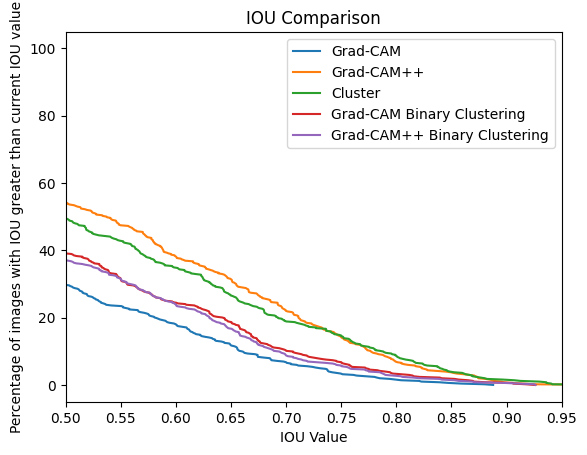

In [104]:
iouBuffGradCAMSorted = np.sort(np.array(iouBuffGradCAM))
iouBuffGradCAMPlusSorted = np.sort(np.array(iouBuffGradCAMPlus))
iouBuffClusterSorted = np.sort(np.array(iouBuffCluster))
iouBuffGradCAMBinaryClustSorted = np.sort(np.array(iouBuffGradCAMBinaryClust))
iouBuffGradCAMPlusBinaryClustSorted = np.sort(np.array(iouBuffGradCAMPlusBinaryClust))

cumulativeSum = (1 - ((np.arange(1,len(iouBuffGradCAM)+1))/len(iouBuffGradCAM))) * 100

plt.figure()
plt.title("IOU Comparison")
plt.plot(iouBuffGradCAMSorted,cumulativeSum,label="Grad-CAM")
plt.plot(iouBuffGradCAMPlusSorted,cumulativeSum,label="Grad-CAM++")
plt.plot(iouBuffClusterSorted,cumulativeSum,label="Cluster")
plt.plot(iouBuffGradCAMBinaryClustSorted,cumulativeSum,label="Grad-CAM Binary Clustering")
plt.plot(iouBuffGradCAMPlusBinaryClustSorted,cumulativeSum,label="Grad-CAM++ Binary Clustering")
plt.legend()
plt.xlabel("IOU Value")
plt.ylabel("Percentage of images with IOU greater than current IOU value")
plt.xlim((0.5,0.95))
plt.show()